Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2497 - val_loss: 0.2482
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2472 - val_loss: 0.2423
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2389 - val_loss: 0.2246
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2148 - val_loss: 0.1809
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1594 - val_loss: 0.1003
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0725 - val_loss: 0.0266
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0156 - val_loss: 0.0078
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 10/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 11/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 12/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0

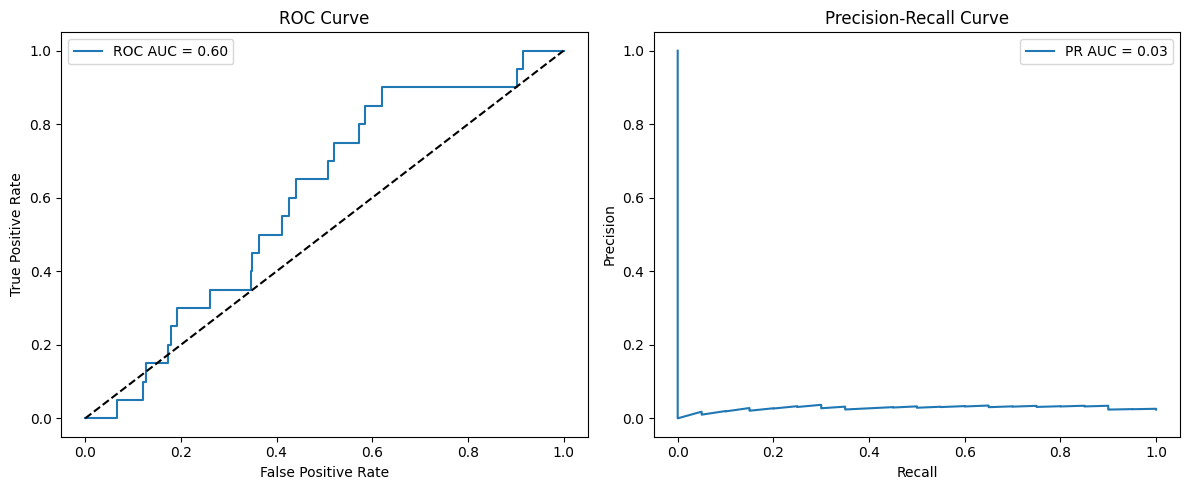

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import __version__ as skl_version
from packaging import version

# --- 1. Adat beolvasás ---
df = pd.read_csv("symptom_clustered_output.csv")

# Feltételezem, hogy az oszlopok nevei: symptoms1, symptoms2, symptoms3, symptoms4, symptoms5
#symptom_cols = ['symptoms1', 'symptoms2', 'symptoms3', 'symptoms4', 'symptoms5']

# Drop symptom oszlopok + Dangerous
#X = df.drop(columns=symptom_cols + ['Dangerous'])
X = df.drop(columns=['Dangerous'])

# Anomália: "no" --> -1, Normál: "yes" --> 1
y_true = df["Dangerous"].map({"no": -1, "yes": 1})

# --- 2. One-hot encoding ---
cat_cols = X.columns.tolist()
if version.parse(skl_version) >= version.parse("1.2"):
    encoder = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)])
else:
    encoder = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), cat_cols)])

X_encoded = encoder.fit_transform(X)

# --- 3. Skálázás ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- 4. Train/test split ---
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=35)

# --- 5. AutoEncoder építés ---
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128, activation="relu")(input_layer)
encoded = Dropout(0.1)(encoded)
encoded = Dense(64, activation="relu")(encoded)
encoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(encoded)
decoded = Dense(128, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0015), loss="mse")

# --- 6. Early stopping callback ---
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

# --- 7. Tanítás ---
autoencoder.fit(
    X_train, X_train,
    epochs=1000,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stop],
    verbose=1
)

# --- 8. Rekonstrukciós hiba számítása ---
X_reconstructed = autoencoder.predict(X_scaled)
recon_error = np.mean(np.square(X_scaled - X_reconstructed), axis=1)
# --- 9. Küszöb keresése, hogy az anomáliák ~2.25% legyenek ---
target_anomaly_ratio = 0.02444987775 # 2.25%
sorted_errors = np.sort(recon_error)
threshold_index = int((1 - target_anomaly_ratio) * len(sorted_errors))
best_thresh = sorted_errors[threshold_index]

print(f"✨ Küszöb az ~2.25% anomália arányhoz: {best_thresh:.6f}")

# --- 10. Végső predikció a kiválasztott küszöbbel ---
y_pred = np.where(recon_error > best_thresh, -1, 1)

# --- 10. Végső predikció a legjobb küszöbbel ---
y_pred = np.where(recon_error > best_thresh, -1, 1)

# --- 11. Kiértékelés ---
print("📋 Classification Report:")
print(classification_report(y_true, y_pred))

# --- 12. ROC és PR AUC ---
y_true_binary = (y_true == -1).astype(int)  # 1=anomália, 0=normál
roc_auc = roc_auc_score(y_true_binary, recon_error)
precision, recall, _ = precision_recall_curve(y_true_binary, recon_error)
pr_auc = auc(recall, precision)

print(f"🔥 ROC AUC: {roc_auc:.4f}")
print(f"🔥 Precision-Recall AUC: {pr_auc:.4f}")

# --- 13. Grafikonok ---
fpr, tpr, _ = roc_curve(y_true_binary, recon_error)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1246 - val_loss: 0.1235
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1229 - val_loss: 0.1203
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1185 - val_loss: 0.1128
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1088 - val_loss: 0.0981
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0906 - val_loss: 0.0739
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0626 - val_loss: 0.0430
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0318 - val_loss: 0.0174
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0113 - val_loss: 0.0062
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 10/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0

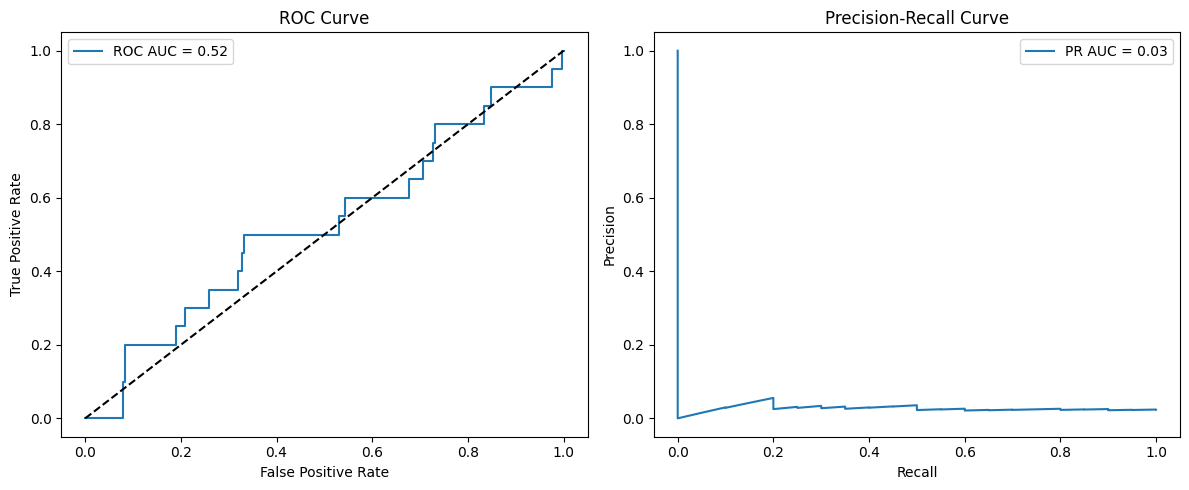

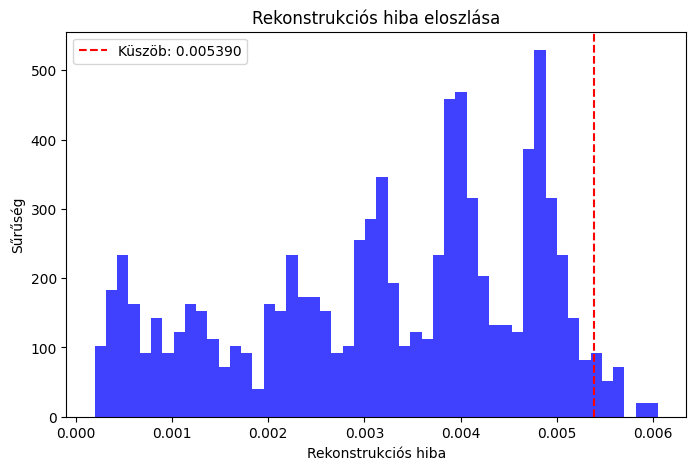

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import __version__ as skl_version
from packaging import version
from tensorflow.keras.losses import Huber

# --- 1. Adat beolvasás ---
df = pd.read_csv("symptom_clustered_output.csv")

# Anomália: "no" --> -1, Normál: "yes" --> 1
y_true = df["Dangerous"].map({"no": -1, "yes": 1})

# --- 2. Oszlopok azonosítása ---
# Kategorikus és numerikus oszlopok szétválasztása
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Ellenőrizzük, hogy a 'Dangerous' oszlop ne legyen a jellemzők között
if 'Dangerous' in cat_cols:
    cat_cols.remove('Dangerous')
if 'Dangerous' in num_cols:
    num_cols.remove('Dangerous')

# Jellemzők (X) kiválasztása (Dangerous nélkül)
X = df[cat_cols + num_cols]

# --- 3. Előfeldolgozás: OneHotEncoder és MinMaxScaler ---
# ColumnTransformer beállítása
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", MinMaxScaler(), num_cols)
    ])

# Előfeldolgozás alkalmazása
X_preprocessed = preprocessor.fit_transform(X)

# --- 4. Train/test split ---
X_train, X_test = train_test_split(X_preprocessed, test_size=0.25, random_state=35)

# --- 5. AutoEncoder építés ---
input_dim = X_preprocessed.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation="relu")(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(16, activation="relu")(encoded)
decoded = Dense(32, activation="relu")(encoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0015), loss=Huber())

# --- 6. Early stopping callback ---
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# --- 7. Tanítás ---
autoencoder.fit(
    X_train, X_train,
    epochs=1000,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stop],
    verbose=1
)

# --- 8. Rekonstrukciós hiba számítása ---
X_reconstructed = autoencoder.predict(X_preprocessed)
recon_error = np.mean(np.square(X_preprocessed - X_reconstructed), axis=1)

# --- 9. Küszöb keresése, hogy az anomáliák ~2.45% legyenek ---
target_anomaly_ratio = 0.02444987775  # 2.45%
sorted_errors = np.sort(recon_error)
threshold_index = int((1 - target_anomaly_ratio) * len(sorted_errors))
best_thresh = sorted_errors[threshold_index]

print(f"✨ Küszöb az ~2.45% anomália arányhoz: {best_thresh:.6f}")

# --- 10. Végső predikció a kiválasztott küszöbbel ---
y_pred = np.where(recon_error > best_thresh, -1, 1)

# --- 11. Kiértékelés ---
print("📋 Classification Report:")
print(classification_report(y_true, y_pred))

# --- 12. ROC és PR AUC ---
y_true_binary = (y_true == -1).astype(int)  # 1=anomália, 0=normál
roc_auc = roc_auc_score(y_true_binary, recon_error)
precision, recall, _ = precision_recall_curve(y_true_binary, recon_error)
pr_auc = auc(recall, precision)

print(f"🔥 ROC AUC: {roc_auc:.4f}")
print(f"🔥 Precision-Recall AUC: {pr_auc:.4f}")

# --- 13. Grafikonok ---
fpr, tpr, _ = roc_curve(y_true_binary, recon_error)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

# --- 14. Rekonstrukciós hiba eloszlása ---
plt.figure(figsize=(8, 5))
plt.hist(recon_error, bins=50, density=True, alpha=0.75, color='blue')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Küszöb: {best_thresh:.6f}')
plt.title('Rekonstrukciós hiba eloszlása')
plt.xlabel('Rekonstrukciós hiba')
plt.ylabel('Sűrűség')
plt.legend()
plt.show()

In [32]:
print("Normál átlag hiba:", np.mean(recon_error[y_true == 1]))
print("Anomália átlag hiba:", np.mean(recon_error[y_true == -1]))


Normál átlag hiba: 0.005103178186075288
Anomália átlag hiba: 0.0052091520862103165


In [31]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.0245, random_state=42)
y_pred_iso = iso.fit_predict(X_scaled)  # -1 = anomália, 1 = normál
print(classification_report(y_true, y_pred_iso))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      0.97      0.97       818

    accuracy                           0.95       838
   macro avg       0.49      0.49      0.49       838
weighted avg       0.95      0.95      0.95       838



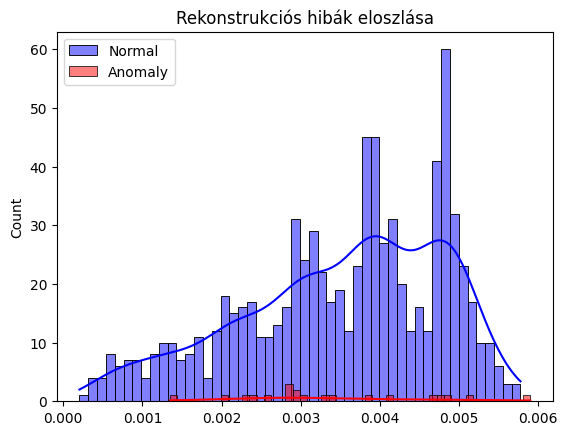

In [29]:
import seaborn as sns
sns.histplot(recon_error[y_true == 1], label="Normal", color="blue", bins=50, kde=True)
sns.histplot(recon_error[y_true == -1], label="Anomaly", color="red", bins=50, kde=True)
plt.legend()
plt.title("Rekonstrukciós hibák eloszlása")
plt.show()


In [21]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.0245, random_state=35)
iso_forest.fit(X_preprocessed)
y_pred_iso = iso_forest.predict(X_preprocessed)
print("📋 Isolation Forest Classification Report:")
print(classification_report(y_true, y_pred_iso))
roc_auc_iso = roc_auc_score(y_true_binary, -iso_forest.decision_function(X_preprocessed))
print(f"🔥 Isolation Forest ROC AUC: {roc_auc_iso:.4f}")
precision_iso, recall_iso, _ = precision_recall_curve(y_true_binary, -iso_forest.decision_function(X_preprocessed))
pr_auc_iso = auc(recall_iso, precision_iso)
print(f"🔥 Isolation Forest PR AUC: {pr_auc_iso:.4f}")

📋 Isolation Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.10      0.10      0.10        20
           1       0.98      0.98      0.98       818

    accuracy                           0.96       838
   macro avg       0.54      0.54      0.54       838
weighted avg       0.96      0.96      0.96       838

🔥 Isolation Forest ROC AUC: 0.4716
🔥 Isolation Forest PR AUC: 0.0322


In [23]:
pip install lazypredict

^C
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
   ---------------------------------------- 0.0/29.0 MB ? eta -:--:--
   - -------------------------------------- 1.3/29.0 MB 9.5 MB/s eta 0:00:03
   ----- ---------------------------------- 3.7/29.0 MB 9.9 MB/s eta 0:00:03
   -------- ------------------------------- 6.0/29.0 MB 10.5 MB/s eta 0:00:03
   ----------- ---------------------------- 8.4/29.0 MB 11.1 MB/s eta 0:00:02
   -------------- ------------------------- 10.5/29.0 MB 10.6 MB/s eta 0:00:02
   ----------------- ---------------------- 12.8/29.0 MB 10.7 MB/s eta 0:00:02
   -------------------- ------------------- 14.9/29.0 MB 10.7 MB/s eta 0:00:02
   ---------------------- ----------------- 16.5/29.0 MB 10.3 MB/s eta 0:00:02
   ------------------------- -------------- 18.4/29.0 MB 10.1 MB/s eta 0:00:02
   --------------------------- ------------ 20.2/29.0 MB 9.9 MB/s eta 0:00:01
   --------------

✨ Tanító adatkészlet mérete: (670, 3222), Anomáliák aránya: 0.0254


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 17, number of negative: 653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 670, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025373 -> initscore=-3.648364
[LightGBM] [Info] Start training from score -3.648364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


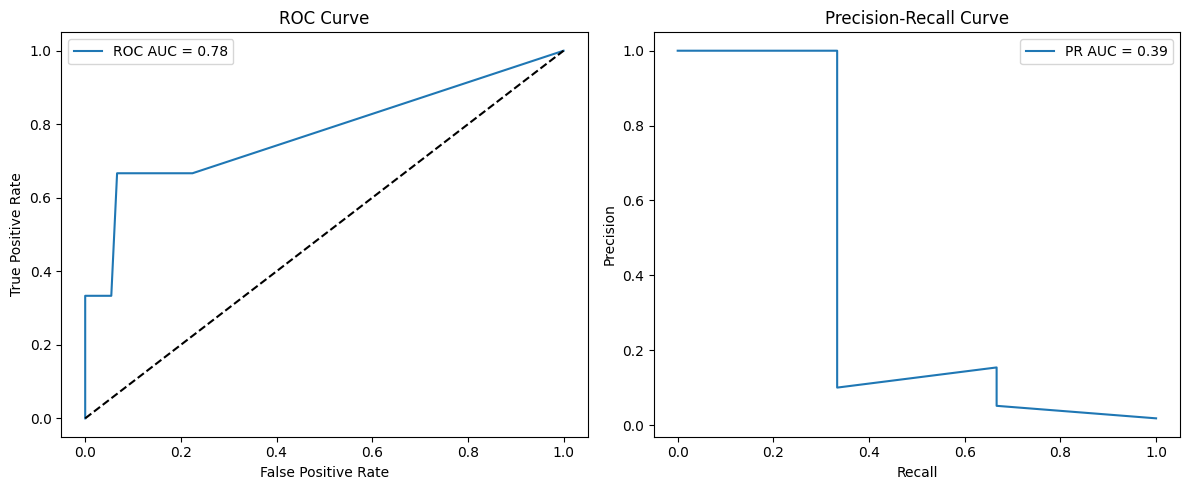

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn import __version__ as skl_version
from packaging import version
from lazypredict.Supervised import LazyClassifier  # LazyClassifier importálása

# --- 1. Adat beolvasás ---
df = pd.read_csv("symptom_clustered_output.csv")

# Anomália: "no" --> -1, Normál: "yes" --> 1
y_true = df["Dangerous"].map({"no": -1, "yes": 1})

# Bináris osztályozási formátum: -1 → 1 (anomália), 1 → 0 (normál)
y_binary = np.where(y_true == -1, 1, 0)

# --- 2. Oszlopok azonosítása ---
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

if 'Dangerous' in cat_cols:
    cat_cols.remove('Dangerous')
if 'Dangerous' in num_cols:
    num_cols.remove('Dangerous')

X = df[cat_cols + num_cols]

# --- 3. Előfeldolgozás: OneHotEncoder és MinMaxScaler ---
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", MinMaxScaler(), num_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# --- 4. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_binary, test_size=0.2, random_state=35)
print(f"✨ Tanító adatkészlet mérete: {X_train.shape}, Anomáliák aránya: {(y_train == 1).sum() / len(y_train):.4f}")

# --- 5. LazyClassifier futtatása ---
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# --- 6. Modellek teljesítményének kiírása ---
print("📋 LazyClassifier Model Performance:")
print(models)

# --- 7. Legjobb modell kiválasztása (pl. ROC AUC alapján) ---
best_model_name = models.index[0]  # Az első modell a legjobb ROC AUC szerint
print(f"✨ Legjobb modell: {best_model_name}")

# --- 8. Legjobb modell újrafuttatása és kiértékelése ---
from sklearn.ensemble import RandomForestClassifier  # Példa: ha a RandomForest a legjobb
best_model = RandomForestClassifier(random_state=35)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Valószínűség az anomália osztályra

# --- 9. Kiértékelés ---
print("📋 Classification Report (Legjobb modell):")
print(classification_report(y_test, y_pred))

# ROC és PR AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

print(f"🔥 ROC AUC: {roc_auc:.4f}")
print(f"🔥 Precision-Recall AUC: {pr_auc:.4f}")

# --- 10. Grafikonok ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import genpareto
import numpy as np

# --- 1. Válaszd ki a rekonstrukciós hibák nagy értékeit, pl. 80%-os kvantilis felettieket ---
threshold_quantile = np.percentile(recon_error[y_true == 1], 80)
excesses = recon_error[recon_error > threshold_quantile] - threshold_quantile

# --- 2. Illeszd a Generalized Pareto Distribution-t (GPD) az excessekre ---
params = genpareto.fit(excesses)

# --- 3. Állítsd be az EVT alapú küszöböt úgy, hogy kb. 2.25% legyen az anomália arány ---
target_anomaly_ratio = 0.02444987775
n = len(recon_error)
# Az anomália a legnagyobb hibák 2.25%-a → a küszöb az n*(1-0.0225)-edik elem körül van a rendezett hibák között
sorted_errors = np.sort(recon_error)
threshold_index = int((1 - target_anomaly_ratio) * n)
target_threshold = sorted_errors[threshold_index]

# --- 4. Az EVT küszöb a target_threshold felett legyen, így beállítjuk p_val-t dinamikusan ---
excess_for_target = target_threshold - threshold_quantile
p_val_dynamic = 1 - genpareto.cdf(excess_for_target, *params)
gpd_threshold = threshold_quantile + genpareto.ppf(1 - p_val_dynamic, *params)

print(f"Dinamikus EVT küszöb (kb. 2.25% anomália): {gpd_threshold:.6f}")

# --- 5. Jelöld az anomáliákat a rekonstrukciós hibák alapján ---
y_pred_evt = np.where(recon_error > gpd_threshold, -1, 1)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_evt))


Dinamikus EVT küszöb (kb. 2.25% anomália): 0.005523
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      0.98      0.98       818

    accuracy                           0.95       838
   macro avg       0.49      0.49      0.49       838
weighted avg       0.95      0.95      0.95       838



In [95]:
from sklearn.metrics import classification_report
from scipy.stats import genpareto
import numpy as np

quantiles = [80,85, 90, 95]
p_vals = [0.01, 0.05, 0.1]

for q in quantiles:
    threshold_quantile = np.percentile(recon_error[y_true == 1], q)
    excesses = recon_error[recon_error > threshold_quantile] - threshold_quantile
    if len(excesses) < 10:
        print(f"Kevés excess adat a {q}%-os kvantilisnél, kihagyva.")
        continue
    c, loc, scale = genpareto.fit(excesses)
    for p_val in p_vals:
        gpd_threshold = threshold_quantile + genpareto.ppf(1 - p_val, c, loc=loc, scale=scale)
        y_pred_evt = np.where(recon_error > gpd_threshold, -1, 1)
        print(f"Quantile: {q}%, p_val: {p_val}")
        print(f"EVT küszöb: {gpd_threshold:.6f}")
        print(classification_report(y_true, y_pred_evt))


Quantile: 80%, p_val: 0.01
EVT küszöb: 0.009763
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           0.98       838
   macro avg       0.49      0.50      0.49       838
weighted avg       0.95      0.98      0.96       838

Quantile: 80%, p_val: 0.05
EVT küszöb: 0.007507
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           0.98       838
   macro avg       0.49      0.50      0.49       838
weighted avg       0.95      0.98      0.96       838

Quantile: 80%, p_val: 0.1
EVT küszöb: 0.006959
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           

c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Quantile: 95%, p_val: 0.01
EVT küszöb: 0.006896
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           0.98       838
   macro avg       0.49      0.50      0.49       838
weighted avg       0.95      0.98      0.96       838

Quantile: 95%, p_val: 0.05
EVT küszöb: 0.006598
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           0.98       838
   macro avg       0.49      0.50      0.49       838
weighted avg       0.95      0.98      0.96       838

Quantile: 95%, p_val: 0.1
EVT küszöb: 0.006525
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        20
           1       0.98      1.00      0.99       818

    accuracy                           

c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [97]:
from sklearn.svm import OneClassSVM
import numpy as np
from sklearn.metrics import classification_report

# Feltételezem, hogy recon_error egy 1D vektor,
# ezért alakítsuk át 2D-be (SVM-nek kell)
X = recon_error.reshape(-1, 1)

# Csak a "normális" mintákat használjuk a tanításhoz (y_true == 1)
X_train = X[y_true == 1]

# One-Class SVM példányosítása
ocsvm = OneClassSVM(kernel='rbf', nu=0.025)  # nu=az anomália arány várható upper bound-ja

# Tanítás
ocsvm.fit(X_train)

# Predikció a teljes adathalmazon
y_pred = ocsvm.predict(X)

# One-Class SVM predikció: +1 = normális, -1 = anomália
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

          -1       0.05      0.05      0.05        20
           1       0.98      0.97      0.98       818

    accuracy                           0.95       838
   macro avg       0.51      0.51      0.51       838
weighted avg       0.95      0.95      0.95       838

